# Problem2

In [3]:
train_data
test_data

,Id,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses,Class
0,1002945,5,4,4,5,7,10.0,3,2,1,0
1,1017122,8,10,10,8,7,10.0,9,7,1,1
2,1018099,1,1,1,1,2,10.0,3,1,1,0
3,1033078,4,2,1,1,2,1.0,2,1,1,0
4,1041801,5,3,3,3,2,3.0,4,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...
294,1371026,5,10,10,10,4,10.0,5,6,3,1
295,1371920,5,1,1,1,2,1.0,3,2,1,0
296,466906,1,1,1,1,2,1.0,1,1,1,0
297,466906,1,1,1,1,2,1.0,1,1,1,0


--- Summary for: Logistic Regression (All) ---
              precision    recall  f1-score   support

      benign       0.96      0.97      0.97       195
   malignant       0.94      0.93      0.94       104

    accuracy                           0.96       299
   macro avg       0.95      0.95      0.95       299
weighted avg       0.96      0.96      0.96       299

--------------------------------------------------

--- Summary for: Logistic Regression (Selected) ---
              precision    recall  f1-score   support

      benign       0.95      0.97      0.96       195
   malignant       0.95      0.91      0.93       104

    accuracy                           0.95       299
   macro avg       0.95      0.94      0.95       299
weighted avg       0.95      0.95      0.95       299

--------------------------------------------------

--- Summary for: LDA (All) ---
              precision    recall  f1-score   support

      benign       0.95      0.98      0.96       195
   

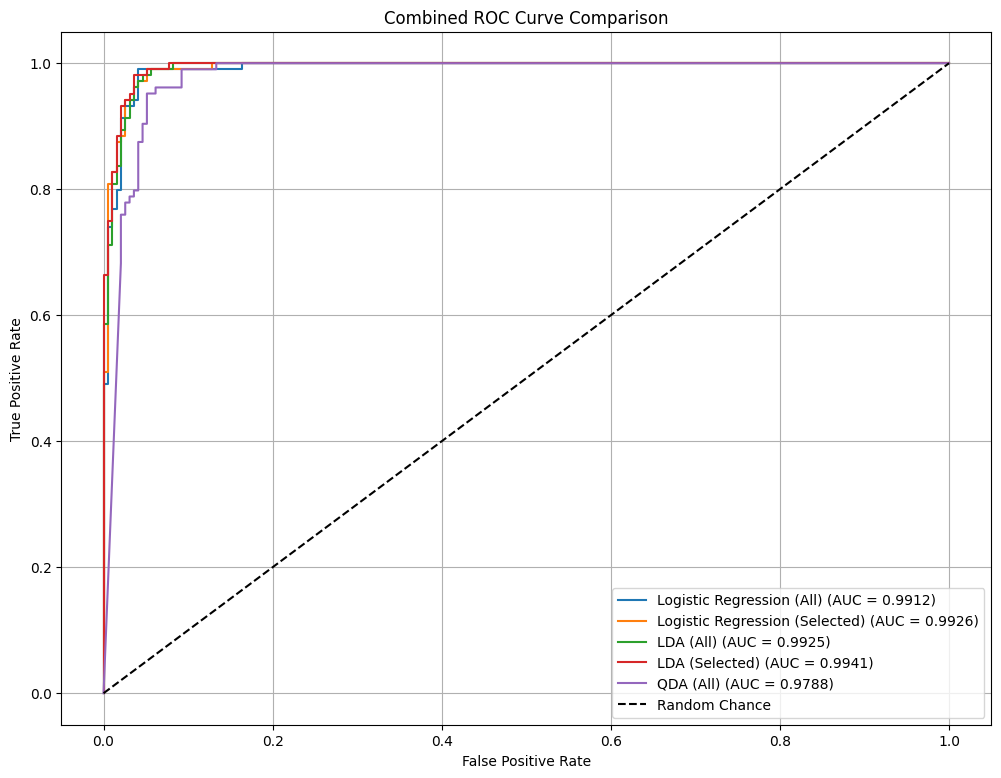

--- Final AUC Score Comparison --- 
                                AUC Score
LDA (Selected)                   0.994083
Logistic Regression (Selected)   0.992554
LDA (All)                        0.992505
Logistic Regression (All)        0.991223
QDA (All)                        0.978797


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

# --- Data Loading and Preprocessing ---

train_data = pd.read_csv('/root/MSDM5054/HW2/BreastCancer_train.csv')

test_data = pd.read_csv('/root/MSDM5054/HW2/BreastCancer_test.csv')
train_data['Class'] = train_data['Class'].map({'benign': 0, 'malignant': 1})
test_data['Class'] = test_data['Class'].map({'benign': 0, 'malignant': 1})

X_train_full = train_data.drop(columns=['Id', 'Class'])
y_train = train_data['Class']
X_test_full = test_data.drop(columns=['Id', 'Class'])
y_test = test_data['Class']

selected_features = ['Cl.thickness', 'Cell.shape', 'Marg.adhesion', 'Bare.nuclei', 'Bl.cromatin']
X_train_selected = X_train_full[selected_features]
X_test_selected = X_test_full[selected_features]

imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# Preprocess full and selected feature sets
X_train_full = scaler.fit_transform(imputer.fit_transform(X_train_full))
X_test_full = scaler.transform(imputer.transform(X_test_full))
X_train_selected = scaler.fit_transform(imputer.fit_transform(X_train_selected))
X_test_selected = scaler.transform(imputer.transform(X_test_selected))


# ---  Define, Train, and Summarize All Models ---
models_to_run = {
    "Logistic Regression (All)": (LogisticRegression(), X_train_full, X_test_full),
    "Logistic Regression (Selected)": (LogisticRegression(), X_train_selected, X_test_selected),
    "LDA (All)": (LinearDiscriminantAnalysis(), X_train_full, X_test_full),
    "LDA (Selected)": (LinearDiscriminantAnalysis(), X_train_selected, X_test_selected),
    "QDA (All)": (QuadraticDiscriminantAnalysis(), X_train_full, X_test_full),
}

results = {}
plt.figure(figsize=(12, 9)) # comparison

for name, (model, X_tr, X_te) in models_to_run.items():
    print(f"--- Summary for: {name} ---")
    
    # Fit model
    model.fit(X_tr, y_train)
    
    # Predictions 
    y_pred = model.predict(X_te)
    print(classification_report(y_test, y_pred, target_names=['benign', 'malignant']))
    
    # Probabilities
    y_prob = model.predict_proba(X_te)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_test, y_prob)
    results[name] = auc
    
    # PROC curve 
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
    print("-" * 50 + "\n")

# ---Comparison ---
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.savefig('ROC_Curve_Comparison.png')
plt.show()

print("--- Final AUC Score Comparison --- ")
auc_summary = pd.DataFrame.from_dict(results, orient='index', columns=['AUC Score'])
print(auc_summary.sort_values(by='AUC Score', ascending=False))

# Problem3

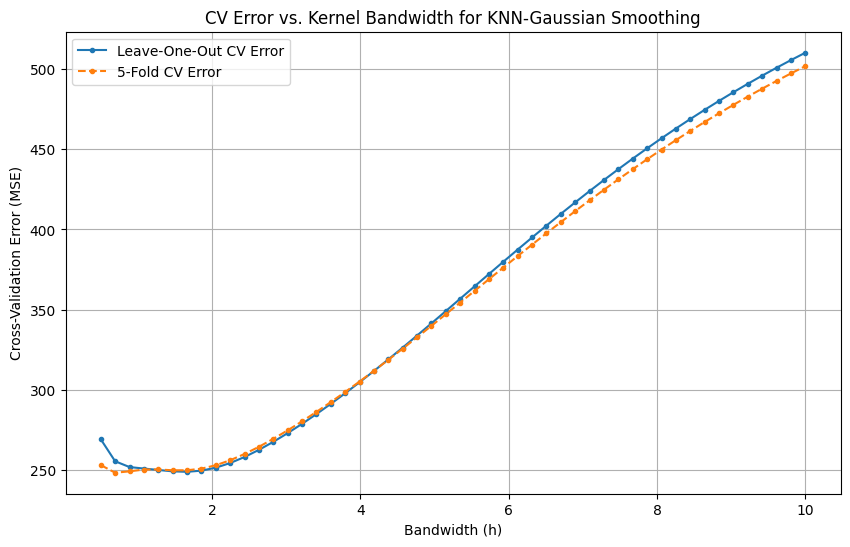

Best bandwidth (h) with LOO-CV: 1.66
Best bandwidth (h) with 5-Fold CV: 0.69


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import mean_squared_error

# --- Load and Prepare Data ---
data = pd.read_csv('/root/MSDM5054/HW2/cars.csv')
X = data[['speed']].values
y = data['dist'].values

# --- Define the Gaussian Kernel Regression Model ---
class KernelRegression:
    def __init__(self, bandwidth=1.0):
        self.bandwidth = bandwidth
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, X_test):
        preds = []
        for x_test_point in X_test:
            # Calculate Gaussian kernel weights for all training points
            # weights = exp(- (distance^2) / (2 * h^2) )
            weights = np.exp(-np.sum((self.X_train - x_test_point)**2, axis=1) / (2 * self.bandwidth**2))
            
            # Weighted average of target values
            # prediction = sum(weights * y_train) / sum(weights)
            prediction = np.sum(weights * self.y_train) / np.sum(weights)
            preds.append(prediction)
        return np.array(preds)

# --- Perform Cross-Validation to Find the Best Bandwidth `h` ---
bandwidths = np.linspace(0.5, 10, 50) 
loo_cv_errors = []
kfold_cv_errors = []

# --- Leave-One-Out CV ---
loo = LeaveOneOut()
for h in bandwidths:
    model = KernelRegression(bandwidth=h)
    errors = []
    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        errors.append(mean_squared_error(y_test, y_pred))
    loo_cv_errors.append(np.mean(errors))

# --- 5-Fold CV ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for h in bandwidths:
    model = KernelRegression(bandwidth=h)
    errors = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        errors.append(mean_squared_error(y_test, y_pred))
    kfold_cv_errors.append(np.mean(errors))

# --- Plot the CV Errors vs. Bandwidth ---
plt.figure(figsize=(10, 6))
plt.plot(bandwidths, loo_cv_errors, marker='.', linestyle='-', label='Leave-One-Out CV Error')
plt.plot(bandwidths, kfold_cv_errors, marker='.', linestyle='--', label='5-Fold CV Error')
plt.xlabel('Bandwidth (h)')
plt.ylabel('Cross-Validation Error (MSE)')
plt.title('CV Error vs. Kernel Bandwidth for KNN-Gaussian Smoothing')
plt.legend()
plt.grid(True)
plt.savefig('Bandwidth.png')
plt.show()

# --- Report the Best Bandwidth ---
best_h_loo = bandwidths[np.argmin(loo_cv_errors)]
best_h_kfold = bandwidths[np.argmin(kfold_cv_errors)]

print(f"Best bandwidth (h) with LOO-CV: {best_h_loo:.2f}")
print(f"Best bandwidth (h) with 5-Fold CV: {best_h_kfold:.2f}")

# Problem4

--- 1. Data Loading and Preprocessing ---
Data preprocessing complete.

--- Task 1: Initial Logistic Regression Model Summary ---
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      885
Method:                           MLE   Df Model:                            5
Date:                Mon, 13 Oct 2025   Pseudo R-squ.:                  0.3342
Time:                        17:38:27   Log-Likelihood:                -395.01
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 1.576e-83
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6499      0.091     -7.126      0.000      -0.829      -0.471
x

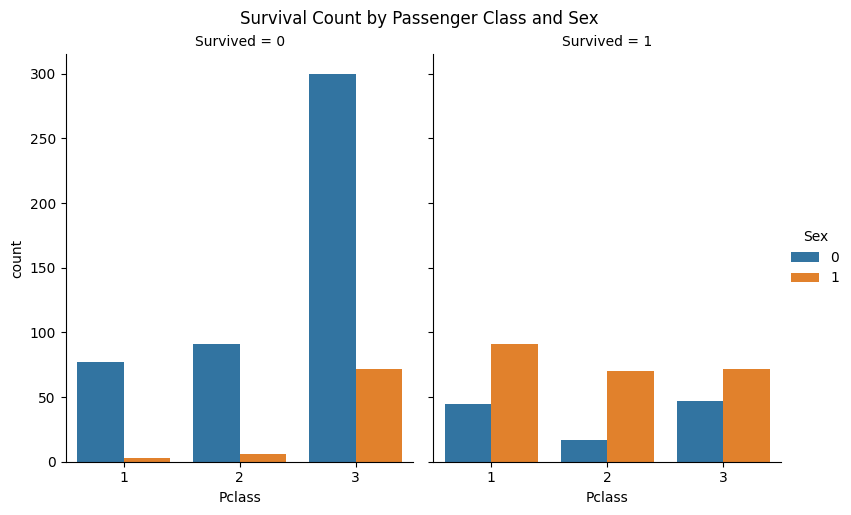

Finding: The plot clearly shows that females (Sex=1) had a much higher survival rate across all classes,
and passengers in 1st class had a higher survival rate than those in 3rd class.

--- Task 4: ROC Curve for Logistic Regression on Training Data ---


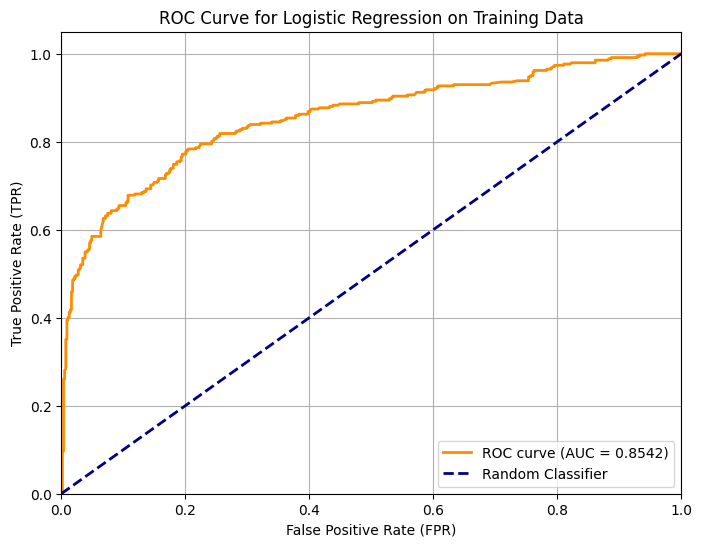

95% Prediction Interval (Logistic Regression): [0.0655, 0.1209]

--- Task 5: QDA Prediction Interval for First Observation ---
Point Prediction (QDA): 0.0527
95% Prediction Interval (QDA): [0.0284, 0.0879]


In [10]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.utils import resample
from sklearn.exceptions import ConvergenceWarning
import warnings
from sklearn.metrics import roc_curve, roc_auc_score

# Suppress convergence warnings for cleaner output
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ---  Data Loading and Preprocessing ---
print("--- 1. Data Loading and Preprocessing ---")
df = pd.read_csv('/root/MSDM5054/HW2/titanic.csv')

df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['Age'] = df['Age'].fillna(df['Age'].median()) # Use median for age as it's more robust to outliers

# Define predictors and response
predictors = ['Pclass', 'Sex', 'Age', 'SibSp', 'Fare']
X = df[predictors]
y = df['Survived']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=predictors) # For easier resampling

print("Data preprocessing complete.\n")


# ---  Task 1: Fit Logistic Regression Model ---
print("--- Task 1: Initial Logistic Regression Model Summary ---")
X_sm = sm.add_constant(X_scaled)
logit_model = sm.Logit(y, X_sm)
result = logit_model.fit(disp=0) # disp=0 suppresses fitting output

# Print a formatted summary
print(result.summary())
stats_intervals = result.conf_int()
stats_intervals.columns = ['Statsmodels 2.5%', 'Statsmodels 97.5%']
print("\n")


# --- Task 2: Bootstrap for Coefficient Confidence Intervals ---
print("--- Task 2: Bootstrap Confidence Intervals vs. Statsmodels ---")
n_iterations = 1000
bootstrap_coefs = []

for i in range(n_iterations):
    # Resample with replacement
    X_resample, y_resample = resample(X_scaled, y)
    
    # Fit model on resampled data
    model = sm.Logit(y_resample, sm.add_constant(X_resample)).fit(disp=0)
    bootstrap_coefs.append(model.params)

# Calculate 95% confidence intervals from bootstrap percentiles
bootstrap_coefs_df = pd.DataFrame(bootstrap_coefs, columns=['const'] + predictors)
bootstrap_intervals = bootstrap_coefs_df.quantile([0.025, 0.975]).T
bootstrap_intervals.columns = ['Bootstrap 2.5%', 'Bootstrap 97.5%']

# Compare the two sets of intervals
comparison_df = pd.concat([stats_intervals, bootstrap_intervals], axis=1)
print(comparison_df)
print("\nFinding: The bootstrapped confidence intervals are very similar to those reported by statsmodels,")
print("which validates the statistical significance and stability of the coefficients.\n")


# --- Task 3: Exploratory Data Analysis ---
print("--- Task 3: Exploratory Data Analysis Plot ---")
sns.catplot(x="Pclass", hue="Sex", col="Survived", data=df, kind="count", height=5, aspect=0.8)
plt.suptitle('Survival Count by Passenger Class and Sex', y=1.02)
plt.savefig('Data_Analysis.png')
plt.show()
print("Finding: The plot clearly shows that females (Sex=1) had a much higher survival rate across all classes,")
print("and passengers in 1st class had a higher survival rate than those in 3rd class.\n")


# Isolate the first observation as the test point
X_train = X_scaled[1:]
y_train = y.iloc[1:]
X_test = X_scaled[0].reshape(1, -1)

print("--- Task 4: ROC Curve for Logistic Regression on Training Data ---")

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predict probabilities on training data
y_scores = log_reg.predict_proba(X_train)[:, 1]

# Calculate the AUC score directly from true labels and scores.

roc_auc = roc_auc_score(y_train, y_scores)
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
# -------------------------

# Plot ROC curve
plt.figure(figsize=(8, 6))
# Use the roc_auc variable we just calculated
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Logistic Regression on Training Data')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('Training_Data_Curve.png')
plt.show()

# Bootstrap for the prediction interval
boot_preds_log = []
for i in range(n_iterations):
    X_resample, y_resample = resample(X_train, y_train)
    log_reg.fit(X_resample, y_resample)
    boot_preds_log.append(log_reg.predict_proba(X_test)[0, 1])

# Calculate and report the 95% prediction interval
lower_log = np.percentile(boot_preds_log, 2.5)
upper_log = np.percentile(boot_preds_log, 97.5)
print(f"95% Prediction Interval (Logistic Regression): [{lower_log:.4f}, {upper_log:.4f}]\n")


# --- Task 5: QDA Prediction Interval ---
print("--- Task 5: QDA Prediction Interval for First Observation ---")
# Train QDA model and get a single point prediction
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
point_pred_qda = qda.predict_proba(X_test)[0, 1]
print(f"Point Prediction (QDA): {point_pred_qda:.4f}")

# Bootstrap for the prediction interval
boot_preds_qda = []
for i in range(n_iterations):
    X_resample, y_resample = resample(X_train, y_train)
    qda.fit(X_resample, y_resample)
    boot_preds_qda.append(qda.predict_proba(X_test)[0, 1])

# Calculate and report the 95% prediction interval
lower_qda = np.percentile(boot_preds_qda, 2.5)
upper_qda = np.percentile(boot_preds_qda, 97.5)
print(f"95% Prediction Interval (QDA): [{lower_qda:.4f}, {upper_qda:.4f}]")